# Lucanode evaluation

Evaluate the FP reduction classifier performance using ROC and AUC.

Also evaluate the FROC of both the UNET segmentation + classifier.

There are 2 FP reduction strategies. One of them based on features extracted from the UNET labeled candidates. The second one is a Resnet50 trained with `candidates_v2.csv`.

For the UNET-based classifier, I'm using the candidates of subsets 0 to 8 as training data. Subset 9 is ONLY used for testing the performance of the system (also, the UNET has never been trained on subset 9, so there should not be bias in that sense).

For the Resnet classifier the training has been performed with candidates from subsets 0 to 7, while using subset 8 to control for validation loss when adjusting the weights on each epoch end. Subset 9 has been completely excluded and is solely used for testing.

In [1]:
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
sns.set()
%matplotlib inline

/Users/octavi/miniconda3/envs/lucanode/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Adjust these as needed
DATASET_DIR = Path("/Volumes/DATASETS/LUNA")
NETWORK = "evaluation_fp_reduction_resnet_50_augmentation_normalization_dice_3ch_laplacian_731fe9e"


Loading the segmentation candidates and annotations

In [3]:
df_ann = pd.read_csv(DATASET_DIR / "CSVFILES/annotations.csv", index_col=0)
df_ann_excluded = pd.read_csv(DATASET_DIR / "CSVFILES/annotations_excluded.csv")

results_dir = DATASET_DIR / "results" / NETWORK
df_train = pd.concat(
    (pd.read_csv(p, index_col=0) for p in results_dir.glob("candidates_proba_subset[0-8].*")),
    ignore_index=True
)
df_test = pd.concat(
    (pd.read_csv(p, index_col=0) for p in results_dir.glob("candidates_proba_subset9.*")),
    ignore_index=True
)

df_ann_train = df_ann[df_ann.subset.isin([0,1,2,3,4,5,6,7,8])]
df_ann_test = df_ann[df_ann.subset.isin([9])]
df_ann_excluded_train = df_ann_excluded[df_ann_excluded.seriesuid.isin(df_ann_train.seriesuid)]
df_ann_excluded_test = df_ann_excluded[df_ann_excluded.seriesuid.isin(df_ann_test.seriesuid)]

Now match the candidates with their corresponding annotations, if any. Remember that LUNA has a list of excluded annotations that do not count as FP nor as TP. Basically they are abnormalities in the scan that have not been agreed as nodules by a majority of radiologists (3 out of 4) but still could be useful for diagnosis. For practical purposes, what this means is that I will remove any of those matches from the list and not count it to train the classifiers or evaluate the network.

In [4]:
# Match candidates with marked annotations
df_train_match = df_ann_train.reset_index().merge(df_train.reset_index(), on="seriesuid")
df_train_match["distance"] = (
    np.sqrt(
        (df_train_match["coordX_x"] - df_train_match["coordX_y"])**2 + 
        (df_train_match["coordY_x"] - df_train_match["coordY_y"])**2 + 
        (df_train_match["coordZ_x"] - df_train_match["coordZ_y"])**2
    )
)
df_train_match["match"] = df_train_match["distance"] < (df_train_match["diameter_mm_x"] / 2)
candidates_train_TP = df_train_match.groupby("index_y").match.sum()
df_train["match"] = candidates_train_TP
df_train["match"] = df_train["match"].fillna(False)

# Delete candidates with matching excluded annotation
df_train_match = df_ann_excluded_train.reset_index().merge(df_train.reset_index(), on="seriesuid")
df_train_match["distance"] = (
    np.sqrt(
        (df_train_match["coordX_x"] - df_train_match["coordX_y"])**2 + 
        (df_train_match["coordY_x"] - df_train_match["coordY_y"])**2 + 
        (df_train_match["coordZ_x"] - df_train_match["coordZ_y"])**2
    )
)
df_train_match["match"] = df_train_match["distance"] < (df_train_match["diameter_mm_x"] / 2)
candidates_train_TP = df_train_match.groupby("index_y").match.sum()
df_train = df_train.iloc[(candidates_train_TP == 0).index]

# Prepare dataset with features and labels
df_train_features = df_train[["diameter_mm", "squareness", "extent", "layers", "eccentricity_top", "eccentricity_side"]]
df_train_labels = df_train["match"]

In [8]:
# Match candidates with marked annotations
df_test_match = df_ann_test.reset_index().merge(df_test.reset_index(), on="seriesuid")
df_test_match["distance"] = (
    np.sqrt(
        (df_test_match["coordX_x"] - df_test_match["coordX_y"])**2 + 
        (df_test_match["coordY_x"] - df_test_match["coordY_y"])**2 + 
        (df_test_match["coordZ_x"] - df_test_match["coordZ_y"])**2
    )
)
df_test_match["match"] = df_test_match["distance"] < (df_test_match["diameter_mm_x"] / 2)
candidates_test_TP = df_test_match.groupby("index_y").match.sum()
df_test["match"] = candidates_test_TP
df_test["match"] = df_test["match"].fillna(False)

# Delete candidates with matching excluded annotation
df_test_match = df_ann_excluded_test.reset_index().merge(df_test.reset_index(), on="seriesuid")
df_test_match["distance"] = (
    np.sqrt(
        (df_test_match["coordX_x"] - df_test_match["coordX_y"])**2 + 
        (df_test_match["coordY_x"] - df_test_match["coordY_y"])**2 + 
        (df_test_match["coordZ_x"] - df_test_match["coordZ_y"])**2
    )
)
df_test_match["match"] = df_test_match["distance"] < (df_test_match["diameter_mm_x"] / 2)
candidates_test_TP = df_test_match.groupby("index_y").match.sum()
df_test = df_test.iloc[(candidates_test_TP == 0).index]

# Prepare dataset with features and labels
df_test_features = df_test[["diameter_mm", "squareness", "extent", "layers", "eccentricity_top", "eccentricity_side"]]
df_test_labels = df_test["match"]

Now train a bunch of classifiers with the candidate training data we have

In [33]:
classifiers = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

for classifier in classifiers:
    print("training", classifier.__class__)
    classifier.fit(df_train_features.as_matrix(), df_train_labels.as_matrix())

training <class 'sklearn.tree.tree.DecisionTreeClassifier'>
training <class 'sklearn.linear_model.logistic.LogisticRegression'>
training <class 'sklearn.ensemble.forest.RandomForestClassifier'>
training <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
training <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


Once trained, let's have a look at the train and test accuracy

Ratio of FP over len(candidates): 0.908484

** DecisionTreeClassifier classifier **
Accuracy:
	train: 0.9941599281221922 
	test: 0.897998093422307 
	diff: 0.09616183469988526
AUC:
	train: 0.996692
	test: 0.643817


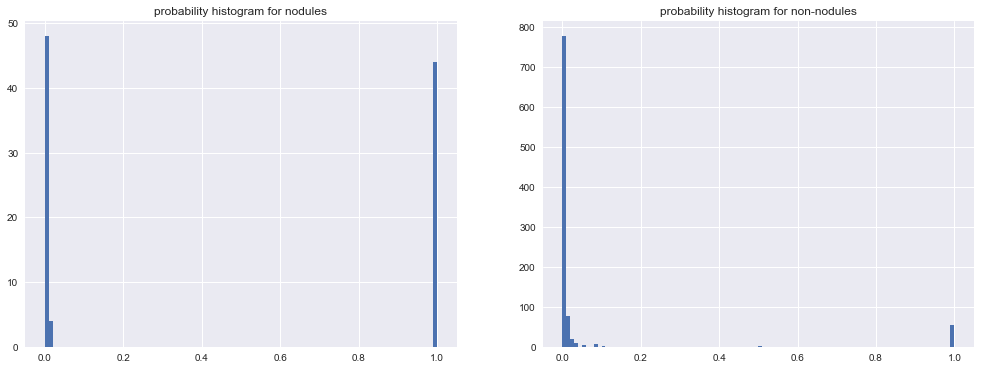


** LogisticRegression classifier **
Accuracy:
	train: 0.9132075471698113 
	test: 0.9113441372735939 
	diff: 0.0018634098962174717
AUC:
	train: 0.867946
	test: 0.831147


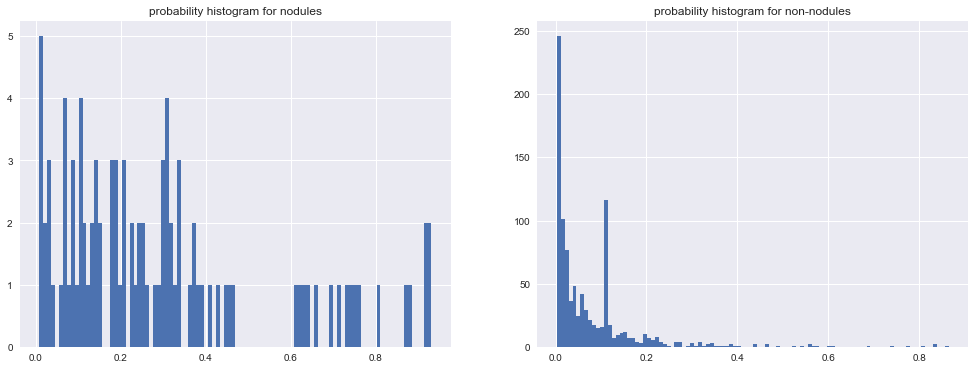


** RandomForestClassifier classifier **
Accuracy:
	train: 0.9885893980233603 
	test: 0.9275500476644424 
	diff: 0.06103935035891794
AUC:
	train: 0.992037
	test: 0.865720


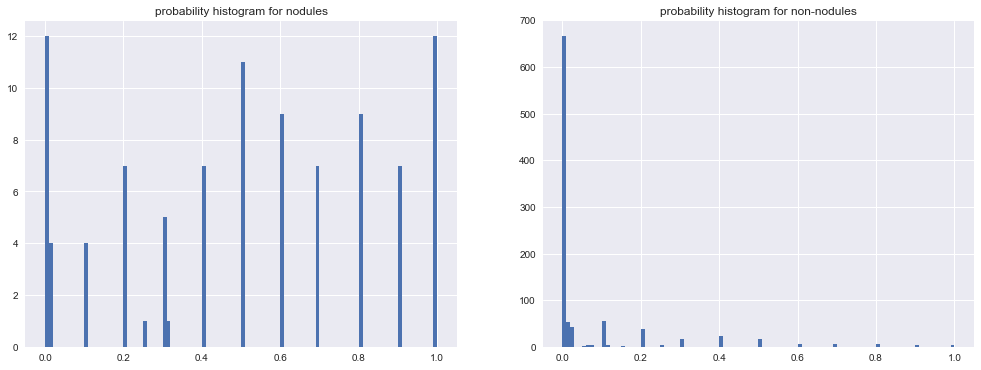


** AdaBoostClassifier classifier **
Accuracy:
	train: 0.9401617250673855 
	test: 0.9256434699714013 
	diff: 0.014518255095984145
AUC:
	train: 0.937495
	test: 0.916907


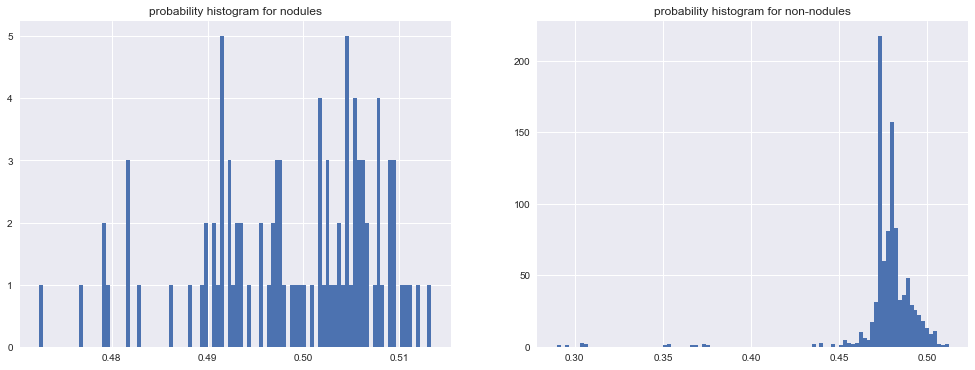


** GradientBoostingClassifier classifier **
Accuracy:
	train: 0.9502246181491465 
	test: 0.9351763584366063 
	diff: 0.015048259712540202
AUC:
	train: 0.948050
	test: 0.916142


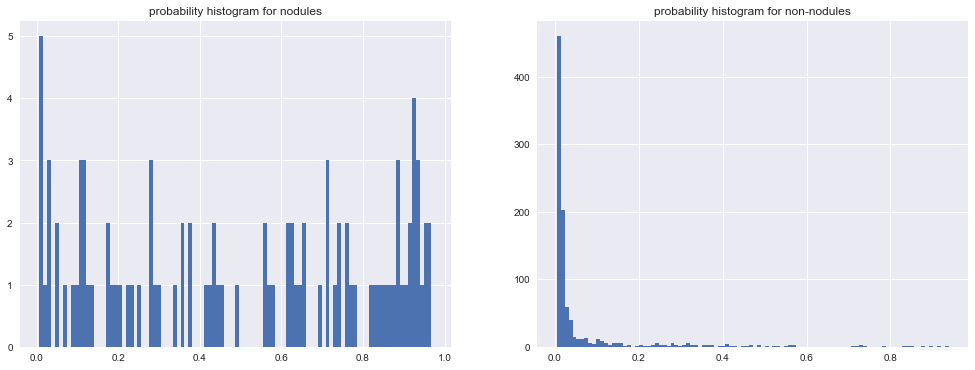

In [34]:
fp_rate = (len(df_test_labels) - df_test_labels.sum()) / len(df_test_labels)
print("Ratio of FP over len(candidates): %f\n" % fp_rate)

names_classifier = [c.__class__.__name__ for c in classifiers]
probs_train = []
probs_test = []
aucs_train = []
aucs_test = []
fprs_train = []
fprs_test = []
tprs_train = []
tprs_test = []

for classifier in classifiers:
    print("** %s classifier **" % classifier.__class__.__name__)
    # Accuracy
    accuracy_train = classifier.score(df_train_features.as_matrix(), df_train_labels.as_matrix())
    accuracy_test = classifier.score(df_test_features.as_matrix(), df_test_labels.as_matrix())
    accuracy_diff = np.abs(accuracy_train - accuracy_test)
    print("Accuracy:", )
    print("\ttrain:", accuracy_train, "\n\ttest:", accuracy_test, "\n\tdiff:", accuracy_diff)
    
    # Predictions
    prob_train = classifier.predict_proba(df_train_features.as_matrix())[:, 1]
    prob_test = classifier.predict_proba(df_test_features.as_matrix())[:, 1]
    probs_train.append(prob_train)
    probs_test.append(prob_test)
    
    # AUC
    auc_train = roc_auc_score(df_train_labels.as_matrix(), prob_train)
    auc_test = roc_auc_score(df_test_labels.as_matrix(), prob_test)
    aucs_train.append(auc_train)
    aucs_test.append(auc_test)
    print("AUC:")
    print("\ttrain: %f\n\ttest: %f" % (auc_train, auc_test))
    
    # FPR and TPR
    fpr_train, tpr_train, _ = roc_curve(df_train_labels.as_matrix(), prob_train)
    fpr_test, tpr_test, _ = roc_curve(df_test_labels.as_matrix(), prob_test)
    fprs_train.append(fpr_train)
    tprs_train.append(tpr_train)
    fprs_test.append(fpr_test)
    tprs_test.append(tpr_test)
    
    df = pd.DataFrame({"label": df_test_labels.as_matrix(), "proba": prob_test})
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(17, 6))
    df[df.label].proba.hist(bins=100, ax=ax1)
    ax1.set_title("probability histogram for nodules")
    df[~df.label].proba.hist(bins=100, ax=ax2)
    ax2.set_title("probability histogram for non-nodules")
    plt.show()
    print("")

# Add ResNet50 data manually
names_classifier.append("Resnet50")

probs_train.append(df_train.probability.as_matrix())
probs_test.append(df_test.probability.as_matrix())

aucs_train.append(roc_auc_score(df_train_labels.as_matrix(), df_train.probability.as_matrix()))
aucs_test.append(roc_auc_score(df_test_labels.as_matrix(), df_test.probability.as_matrix()))

fpr_train, tpr_train, _ = roc_curve(df_train_labels.as_matrix(), df_train.probability.as_matrix())
fpr_test, tpr_test, _ = roc_curve(df_test_labels.as_matrix(), df_test.probability.as_matrix())
fprs_train.append(fpr_train)
fprs_test.append(fpr_test)
tprs_train.append(tpr_train)
tprs_test.append(tpr_test)

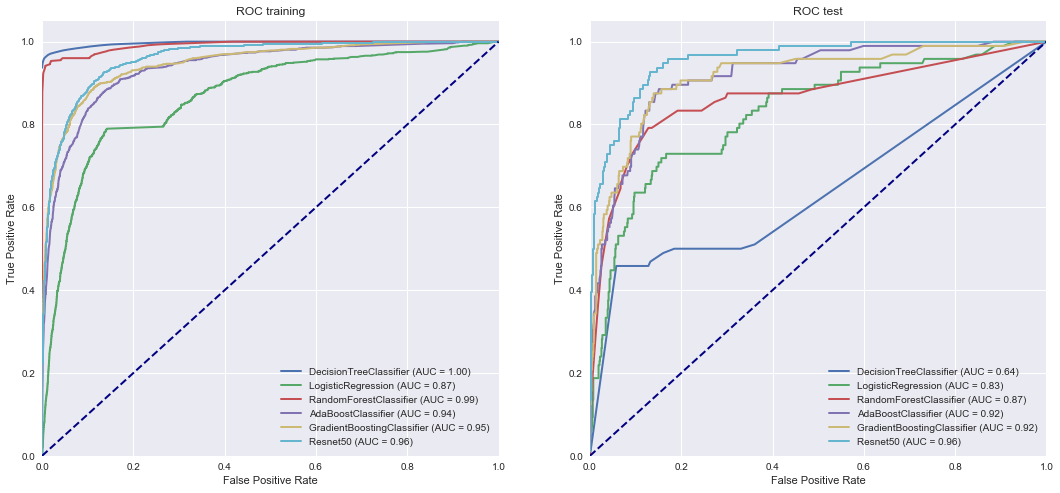

In [35]:
f, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(18, 8))
lw = 2
for name, fpr, tpr, auc in zip(names_classifier, fprs_train, tprs_train, aucs_train):
    ax_train.plot(fpr, tpr, lw=lw, label='%s (AUC = %0.2f)' % (name, auc))
ax_train.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax_train.set_title("ROC training")
ax_train.set_xlim([0.0, 1.0])
ax_train.set_ylim([0.0, 1.05])
ax_train.set_xlabel('False Positive Rate')
ax_train.set_ylabel('True Positive Rate')
ax_train.legend(loc="lower right")

for name, fpr, tpr, auc in zip(names_classifier, fprs_test, tprs_test, aucs_test):
    lw = 2
    ax_test.plot(fpr, tpr, lw=lw, label='%s (AUC = %0.2f)' % (name, auc))
ax_test.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax_test.set_title("ROC test")
ax_test.set_xlim([0.0, 1.0])
ax_test.set_ylim([0.0, 1.05])
ax_test.set_xlabel('False Positive Rate')
ax_test.set_ylabel('True Positive Rate')
ax_test.legend(loc="lower right")

plt.show()

# FROC analysis
Now draw the FROC curve, following the same procedure as in the LUNA challenge

In [39]:
froc_raw_train = {
    "classifier": [],
    "threshold": [],
    "sensitivity": [],
    "FP": []
}
P = len(df_ann_train)
for name, probs in zip(names_classifier, probs_train):
    for th in thresholds:
        y_pred = probs >= th
        TP = (df_train.match & y_pred).sum()
        FP = (~df_train.match & y_pred).sum()
        froc_raw_train["classifier"].append(name)
        froc_raw_train["threshold"].append(th)
        froc_raw_train["FP"].append(FP)
        froc_raw_train["sensitivity"].append(TP / P)
froc_df_train = pd.DataFrame(froc_raw_train)
froc_df_train["mean FP per scan"] = froc_df_train["FP"] / len(df_ann_train.seriesuid.unique())


froc_raw_test = {
    "classifier": [],
    "threshold": [],
    "sensitivity": [],
    "FP": []
}
P = len(df_ann_test)
for name, probs in zip(names_classifier, probs_test):
    for th in thresholds:
        y_pred = probs >= th
        TP = (df_test.match & y_pred).sum()
        FP = (~df_test.match & y_pred).sum()
        froc_raw_test["classifier"].append(name)
        froc_raw_test["threshold"].append(th)
        froc_raw_test["FP"].append(FP)
        froc_raw_test["sensitivity"].append(TP / P)
froc_df_test = pd.DataFrame(froc_raw_test)
froc_df_test["mean FP per scan"] = froc_df_test["FP"] / len(df_ann_test.seriesuid.unique())
froc_df_test.head()

,FP,classifier,sensitivity,threshold,mean FP per scan
0,953,DecisionTreeClassifier,0.914286,0.000000,16.152542
1,344,DecisionTreeClassifier,0.466667,0.001001,5.830508
2,344,DecisionTreeClassifier,0.466667,0.002002,5.830508
3,344,DecisionTreeClassifier,0.466667,0.003003,5.830508
4,315,DecisionTreeClassifier,0.457143,0.004004,5.338983


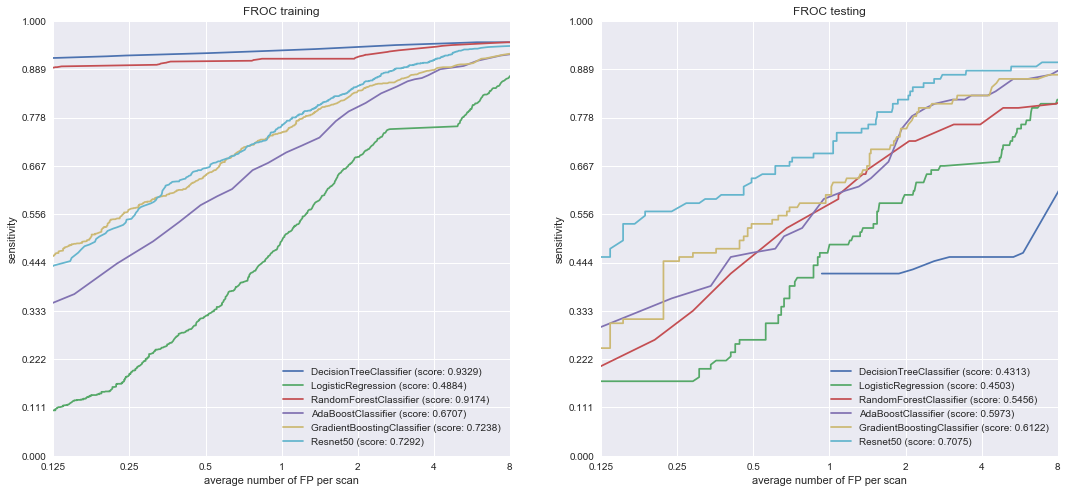

In [52]:
f, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(18, 8))

for name in names_classifier:
    froc_df = froc_df_train[froc_df_train.classifier == name]
    
    score = np.array([
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1/8).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1/4).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1/2).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 2).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 4).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 8).sort_values().index[0]],
    ]).mean()
    
    ax_train.plot(froc_df["mean FP per scan"], froc_df["sensitivity"], label="%s (score: %0.4f)" % (name, score))
ax_train.set_title("FROC training")
ax_train.set_ylim(0, 1)
ax_train.set_yticks(np.linspace(0, 1, 10))
ax_train.set_ylabel("sensitivity")
ax_train.set_xlim(0.125, 8)
ax_train.set_xscale("log")
ax_train.set_xticks([0.125, 0.25, 0.5, 1, 2, 4, 8])
ax_train.set_xticklabels([0.125, 0.25, 0.5, 1, 2, 4, 8])
ax_train.set_xlabel("average number of FP per scan")
ax_train.legend(loc="lower right")

for name in names_classifier:
    froc_df = froc_df_test[froc_df_test.classifier == name]
    
    score = np.array([
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1/8).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1/4).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1/2).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 1).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 2).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 4).sort_values().index[0]],
        froc_df["sensitivity"][np.abs(froc_df["mean FP per scan"] - 8).sort_values().index[0]],
    ]).mean()
    
    ax_test.plot(froc_df["mean FP per scan"], froc_df["sensitivity"], label="%s (score: %0.4f)" % (name, score))
ax_test.set_title("FROC testing")
ax_test.set_ylim(0, 1)
ax_test.set_yticks(np.linspace(0, 1, 10))
ax_test.set_ylabel("sensitivity")
ax_test.set_xlim(0.125, 8)
ax_test.set_xscale("log")
ax_test.set_xticks([0.125, 0.25, 0.5, 1, 2, 4, 8])
ax_test.set_xticklabels([0.125, 0.25, 0.5, 1, 2, 4, 8])
ax_test.set_xlabel("average number of FP per scan")
ax_test.legend(loc="lower right")

plt.show()